# 11.7. AdaGrad算法
## 11.7.1. 稀疏特征和学习率
假设我们正在训练一个语言模型。为了获得良好的准确性，我们大多希望在训练的过程中降低学习率，速度通常为$\mathcal{O}(t^{-\frac{1}{2}})$或更低。现在讨论关于稀疏特征（即只在偶尔出现的特征）的模型训练，这对自然语言来说很常见。例如，我们看到“预先条件”这个词比“学习”这个词的可能性要小得多。但是，它在计算广告学和个性化协同过滤等其他领域也很常见。

只有在这些不常见的特征出现时，与其相关的参数才会得到有意义的更新。鉴于学习率下降，我们可能最终会面临这样的情况：常见特征的参数相当迅速地收敛到最佳值，而对于不常见的特征，我们仍缺乏足够的观测以确定其最佳值。换句话说，学习率要么对于常见特征而言降低太慢，要么对于不常见特征而言降低太快。

解决此问题的一个方法是记录我们看到特定特征的次数，然后将其用作调整学习率。即我们可以使用大小为$\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$的学习率，而不是$\eta = \frac{\eta_0}{\sqrt{t + c}}$。在这里$s(i, t)$计下了我们截至$t$时观察到功能$i$的次数。这其实很容易实施且不产生额外损耗。

AdaGrad算法`Duchi.Hazan.Singer.2011`通过将粗略的计数器$s(i, t)$替换为先前观察所得梯度的平方之和来解决这个问题。它使用$s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$来调整学习率。这有两个好处：首先，我们不再需要决定梯度何时算足够大。其次，它会随梯度的大小自动变化。通常对应于较大梯度的坐标会显著缩小，而其他梯度较小的坐标则会得到更平滑的处理。在实际应用中，它促成了计算广告学及其相关问题中非常有效的优化程序。但是，它遮盖了AdaGrad固有的一些额外优势，这些优势在预处理环境中很容易被理解。

## 11.7.2. 预处理

凸优化问题有助于分析算法的特点。毕竟对于大多数非凸问题来说，获得有意义的理论保证很难，但是直觉和洞察往往会延续。让我们来看看最小化$f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$这一问题。

正如在11.6节中那样，我们可以根据其特征分解$\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$重写这个问题，来得到一个简化得多的问题，使每个坐标都可以单独解出：

$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.\tag{11.7.1}$$

在这里我们使用了$\mathbf{x} = \mathbf{U} \mathbf{x}$，且因此$\mathbf{c} = \mathbf{U} \mathbf{c}$。修改后优化器为$\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$且最小值为$-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$。这样更容易计算，因为$\boldsymbol{\Lambda}$是一个包含$\mathbf{Q}$特征值的对角矩阵。

如果稍微扰动$\mathbf{c}$，我们会期望在$f$的最小化器中只产生微小的变化。
遗憾的是，情况并非如此。虽然$\mathbf{c}$的微小变化导致了$\bar{\mathbf{c}}$同样的微小变化，但$f$的（以及$\bar{f}$的）最小化器并非如此。每当特征值$\boldsymbol{\Lambda}_i$很大时，我们只会看到$\bar{x}_i$和$\bar{f}$的最小值发声微小变化。相反，对于小的$\boldsymbol{\Lambda}_i$来说，$\bar{x}_i$的变化可能是剧烈的。最大和最小的特征值之比称为优化问题的**条件数**（condition number）。

$$\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d}.\tag{11.7.2}$$

如果条件编号$\kappa$很大，准确解决优化问题就会很难。我们需要确保在获取大量动态的特征值范围时足够谨慎：难道我们不能简单地通过扭曲空间来“修复”这个问题，从而使所有特征值都是$1$？理论上这很容易：我们只需要$\mathbf{Q}$的特征值和特征向量即可将问题从$\mathbf{x}$整理到$\mathbf{z} := \boldsymbol{\Lambda}^{\frac{1}{2}} \mathbf{U} \mathbf{x}$中的一个。在新的坐标系中，$\mathbf{x}^\top \mathbf{Q} \mathbf{x}$可以被简化为$\|\mathbf{z}\|^2$。可惜，这是一个相当不切实际的想法。一般而言，计算特征值和特征向量要比解决实际问题“贵”得多。

虽然准确计算特征值可能会很昂贵，但即便只是大致猜测并计算它们，也可能已经比不做任何事情好得多。特别是，我们可以使用$\mathbf{Q}$的对角线条目并相应地重新缩放它。这比计算特征值开销小的多。

$$\tilde{\mathbf{Q}} = \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}).\tag{11.7.3}$$

在这种情况下，我们得到了$\tilde{\mathbf{Q}}_{ij} = \mathbf{Q}_{ij} / \sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}$，特别注意对于所有$i$，$\tilde{\mathbf{Q}}_{ii} = 1$。在大多数情况下，这大大简化了条件数。例如我们之前讨论的案例，它将完全消除眼下的问题，因为问题是轴对齐的。

遗憾的是，我们还面临另一个问题：在深度学习中，我们通常情况甚至无法计算目标函数的二阶导数：对于$\mathbf{x} \in \mathbb{R}^d$，即使只在小批量上，二阶导数可能也需要$\mathcal{O}(d^2)$空间来计算，导致几乎不可行。AdaGrad算法巧妙的思路是，**使用一个代理来表示黑塞矩阵（Hessian）的对角线**，既相对易于计算又高效。

为了了解它是如何生效的，让我们来看看$\bar{f}(\bar{\mathbf{x}})$。我们有

$$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right),\tag{11.7.4}$$

其中$\bar{\mathbf{x}}_0$是$\bar{f}$的优化器。因此，梯度的大小取决于$\boldsymbol{\Lambda}$和与最佳值的差值。如果$\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$没有改变，那这就是我们所求的。毕竟在这种情况下，梯度$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}})$的大小就足够了。由于AdaGrad算法是一种随机梯度下降算法，所以即使是在最佳值中，我们也会看到具有非零方差的梯度。因此，我们可以放心地使用梯度的方差作为黑塞矩阵比例的廉价替代。详尽的分析（要花几页解释）超出了本节的范围，请读者参考`Duchi.Hazan.Singer.2011`。

## 11.7.3.算法

让我们接着上面正式开始讨论。我们使用变量$\mathbf{s}_t$来累加过去的梯度方差，如下所示：

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}\tag{11.7.5}$$

在这里，操作是按照坐标顺序应用。也就是说，$\mathbf{v}^2$有条目$v_i^2$。同样，$\frac{1}{\sqrt{v}}$有条目$\frac{1}{\sqrt{v_i}}$，并且$\mathbf{u} \cdot \mathbf{v}$有条目$u_i v_i$。与之前一样，$\eta$是学习率，$\epsilon$是一个为维持数值稳定性而添加的常数，用来确保我们不会除以$0$。最后，我们初始化$\mathbf{s}_0 = \mathbf{0}$。

就像在动量法中我们需要跟踪一个辅助变量一样，在AdaGrad算法中，我们允许每个坐标有单独的学习率。与SGD算法相比，这并没有明显增加AdaGrad的计算代价，因为主要计算用在$l(y_t, f(\mathbf{x}_t, \mathbf{w}))$及其导数。

请注意，在$\mathbf{s}_t$中累加平方梯度意味着$\mathbf{s}_t$基本上以线性速率增长（由于梯度从最初开始衰减，实际上比线性慢一些）。这产生了一个学习率$\mathcal{O}(t^{-\frac{1}{2}})$，但是在单个坐标的层面上进行了调整。对于凸问题，这完全足够了。然而，在深度学习中，我们可能希望更慢地降低学习率。这引出了许多AdaGrad算法的变体，我们将在后续章节中讨论它们。眼下让我们先看看它在二次凸问题中的表现如何。我们仍然以同一函数为例：

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.\tag{11.7.6}$$

我们将使用与之前相同的学习率来实现AdaGrad算法，即$\eta = 0.4$。可以看到，自变量的迭代轨迹较平滑。但由于$\boldsymbol{s}_t$的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

epoch 20, x1: -2.382563, x2: -0.158591


/home/zhang/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352463056/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


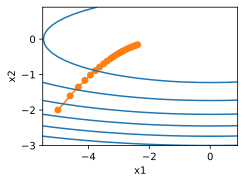

In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

epoch 20, x1: -0.002295, x2: -0.000000


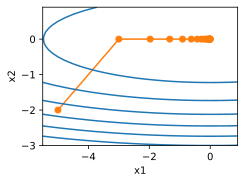

In [2]:
"""
我们将学习率提高到2，可以看到更好的表现。 这已经表明，即使在无噪声的情况下，学习率的降低可能相当剧烈，我们需要确保参数能够适当地收敛。
"""
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## 11.7.4. 从零开始实现
同动量法一样，AdaGrad算法需要对**每个自变量**维护同它一样形状的**状态变量**。

In [3]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

"""
与 11.5节中的实验相比，这里使用更大的学习率来训练模型。
"""
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

loss: 0.244, 0.003 sec/epoch


## 11.7.5. 简洁实现

In [4]:
"""
我们可直接使用深度学习框架中提供的AdaGrad算法来训练模型。
"""
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

loss: 0.243, 0.003 sec/epoch


## 11.7.6. 小结
* AdaGrad算法会在单个坐标层面动态降低学习率。
* AdaGrad算法利用梯度的大小作为调整进度速率的手段：用较小的学习率来补偿带有较大梯度的坐标。
* 在深度学习问题中，由于内存和计算限制，计算准确的二阶导数通常是不可行的。梯度可以作为一个有效的代理。
* 如果优化问题的结构相当不均匀，AdaGrad算法可以帮助缓解扭曲。
* AdaGrad算法对于稀疏特征特别有效，在此情况下由于不常出现的问题，学习率需要更慢地降低。
* 在深度学习问题上，AdaGrad算法有时在降低学习率方面可能过于剧烈。我们将在11.10节讨论缓解这种情况的策略。